In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
class BraessNetwork(object):
    """Stores the cost for all links. Handles calculating the cost of a path given action
       of every car.
    """
    def __init__(self):
        """
        self.__links records the cost functions, more specifically,
        AB -> 1 + flow
        AC -> 2
        BD -> 2
        CD -> 1 + flow
        BC -> 0.25
        """
        self.__links = {
            "AB": lambda f: 1 + f, #(f/100),
            "AC": lambda _: 2,
            "BD": lambda _: 2,
            "CD": lambda f: 1 + f, #(f/100),
            "BC": lambda _: 0.25
        } # Dictionary of links and their congestion functions
        self.__paths = {
            "ABD": ("AB", "BD"),
            "ACD": ("AC", "CD"),
            "ABCD": ("AB", "BC", "CD")
        } # Dictionaries of paths to links
        return 
    
    def paths(self):
        """Gives a list of all possible paths in the network to the environment. 
           The environment could then assign an action number to each path. 
        """
        return ("ABD", "ACD", "ABCD")
    
    def calculate_ttime(self, flows): # the output of this function is our observation: total travel time of each route
        """Given a dictionary of paths and flows, this function returns a dictionary of 
           paths and travel time (secs), a.k.a ttime.
           
           Returns: 
               travel_times (dictionary): A dictionary of paths to their travel times
        """
        congestion = {}
        for path in flows:
            links = self.__paths[path]
            for link in links:
                if link not in congestion:
                    congestion[link] = 0
                congestion[link] += flows[path]
        
        t_time = {}
        for path in flows:
            total_time = 0
            # Calculate travel time of path by adding the congestion time of every 
            # link in that path
            links = self.__paths[path]
            for link in links:
                t_time_func = self.__links[link]
                total_time += t_time_func(congestion[link])
            t_time[path] = total_time
        
        return t_time
    
    def calculate_ttime_lambda(self, flows, Lambda):
        """Given a dictionary of paths and flows, this function returns a dictionary of 
           paths and travel time, considering the social factor lambda (secs).
           
           Returns: 
               travel_times (dictionary): A dictionary of paths to their travel times,
               considering the social factor lambda
        """
        congestion = {}
        for path in flows:
            links = self.__paths[path]
            for link in links:
                if link not in congestion:
                    congestion[link] = 0
                congestion[link] += flows[path]
        
        t_time_lambda = {}
        for path in flows:
            total_time = 0
            # Calculate travel time of path by adding the congestion time of every 
            # link in that path, and plus the social factor
            links = self.__paths[path]
            for link in links:
                if link == "AB" or link == "CD":
                    total_time += Lambda * congestion[link]
                t_time_func = self.__links[link]
                total_time += t_time_func(congestion[link])
            t_time_lambda[path] = total_time
        
        return t_time_lambda

In [3]:
Network = BraessNetwork()
T = 10000   # number of iterations
rho = 5 

# initial action: uniform distribution on each route (i.e., [1/3, 1/3, 1/3])
# _exp and _sqrt correspond to different learning rates
flow_exp = [1/3]*3   
flow_sqrt = [1/3]*3

# dictionaries used to record the output action, i.e., distribution on each route
flows_Hedge_exp = dict(zip(Network.paths(), flow_exp))
flows_Hedge_sqrt = dict(zip(Network.paths(), flow_sqrt))

ttravel_Hedge_exp = np.zeros((T,3))
f_Hedge_exp = np.zeros((T+1,3))
f_Hedge_exp[0,:] = flow_exp
ttravel_Hedge_sqrt = np.zeros((T,3))
f_Hedge_sqrt = np.zeros((T+1,3))
f_Hedge_sqrt[0,:] = flow_sqrt

# Hedge
for i in range(T):
    # current action
    flow_exp = np.array(flow_exp)
    flow_sqrt = np.array(flow_sqrt)
    
    # specify learning rates
    learning_rate_exp = (0.999)**i
    learning_rate_sqrt = 1/np.sqrt(i+1)
    
    # compute the observation, i.e., the total travel time of each route
    travel_time_exp = np.array(list((Network.calculate_ttime(flows_Hedge_exp).values())))
    ttravel_Hedge_exp[i,:] = travel_time_exp
    
    # hedge update, action update
    flow_exp *= np.exp(-learning_rate_exp*travel_time_exp/rho)  
    flow_exp /= sum(flow_exp)
    f_Hedge_exp[i+1,:] = flow_exp
    flows_Hedge_exp = dict(zip(Network.paths(),flow_exp))
    
    travel_time_sqrt = np.array(list((Network.calculate_ttime(flows_Hedge_sqrt).values())))
    ttravel_Hedge_sqrt[i,:] = travel_time_sqrt
    flow_sqrt *= np.exp(-learning_rate_sqrt*travel_time_sqrt/rho)  # hedge update
    flow_sqrt /= sum(flow_sqrt)
    f_Hedge_sqrt[i+1,:] = flow_sqrt
    flows_Hedge_sqrt = dict(zip(Network.paths(),flow_sqrt))
    

In [4]:
Network = BraessNetwork()
T = 10000
rho = 5
flow_exp = [1/3]*3
flow_sqrt = [1/3]*3
flows_Replicator_exp = dict(zip(Network.paths(), flow_exp))
flows_Replicator_sqrt = dict(zip(Network.paths(), flow_sqrt))
ttravel_Replicator_exp = np.zeros((T,3))
f_Replicator_exp = np.zeros((T+1,3))
f_Replicator_exp[0,:] = flow_exp
ttravel_Replicator_sqrt = np.zeros((T,3))
f_Replicator_sqrt = np.zeros((T+1,3))
f_Replicator_sqrt[0,:] = flow_sqrt

# Replicator
for i in range(T):
    learning_rate_exp = (0.999)**i
    learning_rate_exp = 1/np.sqrt(i+1)
    travel_time_exp = np.array(list((Network.calculate_ttime(flows_Replicator_exp).values())))
    ttravel_Replicator_exp[i,:] = travel_time_exp
    mean = np.dot(flow_exp, travel_time_exp)
    flow_exp *= (1 + learning_rate_exp * (mean - travel_time_exp)/rho)  # Replicator update
    flow_exp /= sum(flow_exp)
    f_Replicator_exp[i+1,:] = flow_exp
    flows_Replicator_exp = dict(zip(Network.paths(),flow_exp))
    
    travel_time_sqrt = np.array(list((Network.calculate_ttime(flows_Replicator_sqrt).values())))
    ttravel_Replicator_sqrt[i,:] = travel_time_sqrt
    mean = np.dot(flow_sqrt, travel_time_sqrt)
    flow_sqrt *= (1 + learning_rate_sqrt * (mean - travel_time_sqrt)/rho)  # Replicator update
    flow_sqrt /= sum(flow_sqrt)
    f_Replicator_sqrt[i+1,:] = flow_sqrt
    flows_Replicator_sqrt = dict(zip(Network.paths(),flow_sqrt))


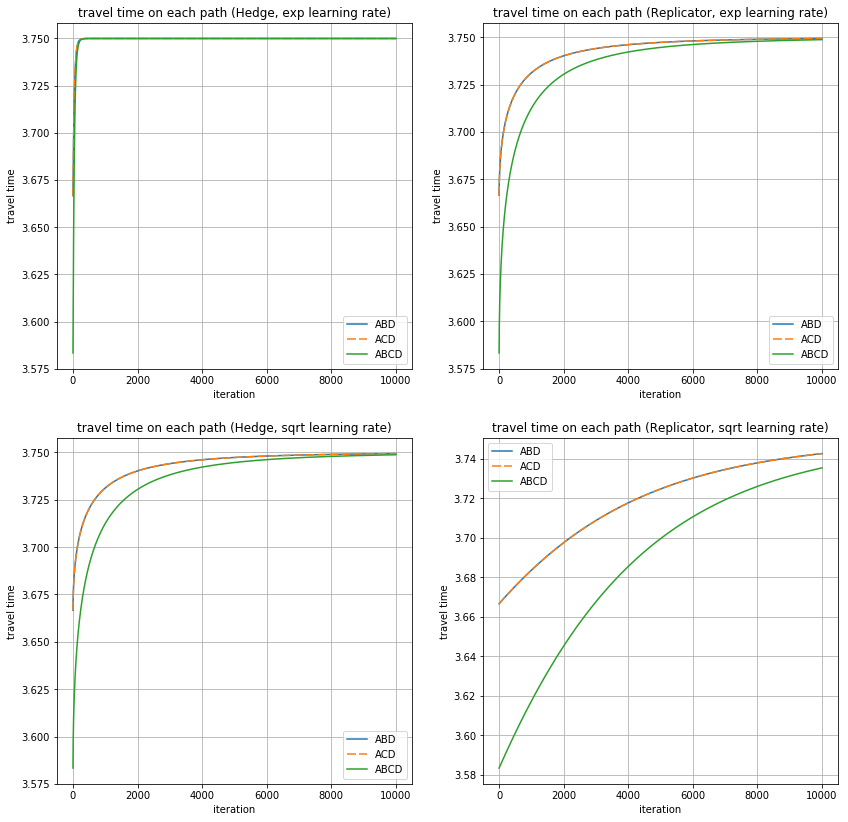

In [5]:
plt.figure(figsize=(14,14))

plt.subplot(221)
time = range(T)
plt.plot(time, ttravel_Hedge_exp[:,0], label='ABD')
plt.plot(time, ttravel_Hedge_exp[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Hedge_exp[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge, exp learning rate)')
plt.grid()
plt.legend()

plt.subplot(222)
time = range(T)
plt.plot(time, ttravel_Replicator_exp[:,0], label='ABD')
plt.plot(time, ttravel_Replicator_exp[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Replicator_exp[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator, exp learning rate)')
plt.grid()
plt.legend()

plt.subplot(223)
time = range(T)
plt.plot(time, ttravel_Hedge_sqrt[:,0], label='ABD')
plt.plot(time, ttravel_Hedge_sqrt[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Hedge_sqrt[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge, sqrt learning rate)')
plt.grid()
plt.legend()

plt.subplot(224)
time = range(T)
plt.plot(time, ttravel_Replicator_sqrt[:,0], label='ABD')
plt.plot(time, ttravel_Replicator_sqrt[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Replicator_sqrt[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator, sqrt learning rate)')
plt.grid()
plt.legend()
plt.show()

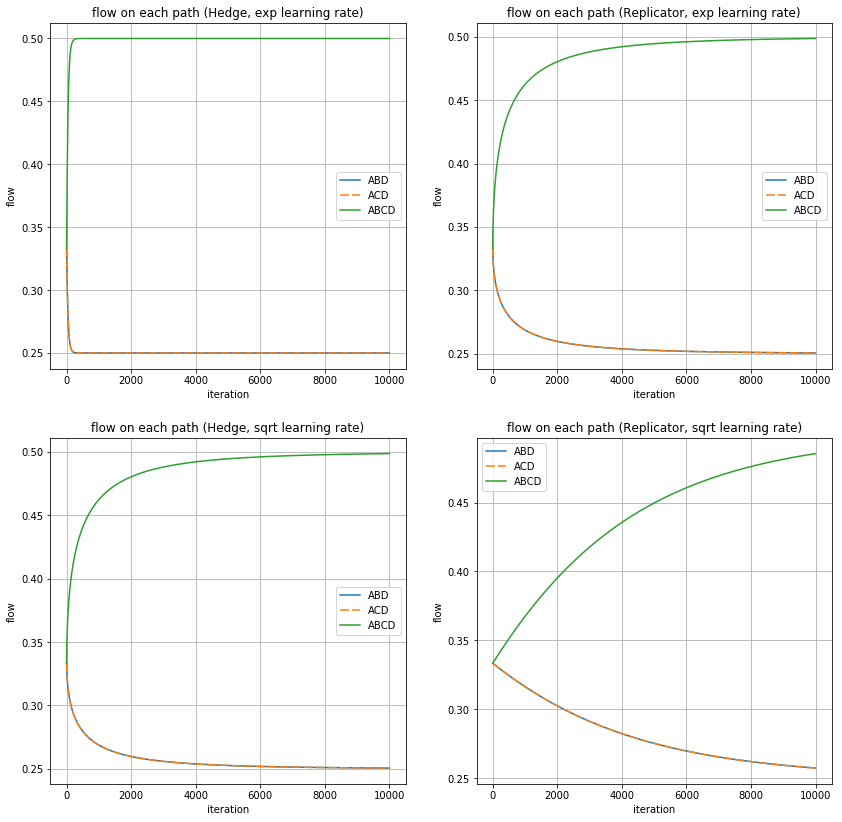

In [6]:
plt.figure(figsize=(14,14))

plt.subplot(221)
time = range(T+1)
plt.plot(time, f_Hedge_exp[:,0], label='ABD')
plt.plot(time, f_Hedge_exp[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Hedge_exp[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('flow')
plt.title('flow on each path (Hedge, exp learning rate)')
plt.grid()
plt.legend()

plt.subplot(222)
time = range(T+1)
plt.plot(time, f_Replicator_exp[:,0], label='ABD')
plt.plot(time, f_Replicator_exp[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Replicator_exp[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('flow')
plt.title('flow on each path (Replicator, exp learning rate)')
plt.grid()
plt.legend()

plt.subplot(223)
time = range(T+1)
plt.plot(time, f_Hedge_sqrt[:,0], label='ABD')
plt.plot(time, f_Hedge_sqrt[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Hedge_sqrt[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('flow')
plt.title('flow on each path (Hedge, sqrt learning rate)')
plt.grid()
plt.legend()

plt.subplot(224)
time = range(T+1)
plt.plot(time, f_Replicator_sqrt[:,0], label='ABD')
plt.plot(time, f_Replicator_sqrt[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Replicator_sqrt[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('flow')
plt.title('flow on each path (Replicator, sqrt learning rate)')
plt.grid()
plt.legend()
plt.show()


In [7]:
# include the lambda factor now
Network = BraessNetwork()
Lambda = 0.5
T = 10000
rho = 5 + 2*Lambda
flow = [1/3]*3
flows_Hedge_lambda = dict(zip(Network.paths(), flow))
ttravel_Hedge_lambda = np.zeros((T,3))
f_Hedge_lambda = np.zeros((T+1,3))
f_Hedge_lambda[0,:] = flow

# Hedge
for i in range(T):
    flow = np.array(flow)
    learning_rate = (0.999)**i#1/np.sqrt(i+1)
    travel_time_lambda = np.array(list((Network.calculate_ttime_lambda(flows_Hedge_lambda, Lambda).values())))
    travel_time = np.array(list((Network.calculate_ttime(flows_Hedge_lambda).values())))
    ttravel_Hedge_lambda[i,:] = travel_time
    flow *= np.exp(-learning_rate*travel_time_lambda/rho)  # hedge update
    flow /= sum(flow)
    f_Hedge_lambda[i+1,:] = flow
    flows_Hedge_lambda = dict(zip(Network.paths(),flow))

In [8]:
Network = BraessNetwork()
Lambda = 0.5
T = 10000
rho = 5 + 2*Lambda
flow = [1/3]*3
flows_Replicator_lambda = dict(zip(Network.paths(),flow))
ttravel_Replicator_lambda = np.zeros((T,3))
f_Replicator_lambda = np.zeros((T+1,3))
f_Replicator_lambda[0,:] = flow

# Replicator
for i in range(T):
    learning_rate = (0.999)**i#1/np.sqrt(i+1)
    travel_time_lambda = np.array(list((Network.calculate_ttime_lambda(flows_Replicator_lambda, Lambda).values())))
    travel_time = np.array(list((Network.calculate_ttime(flows_Replicator_lambda).values())))
    ttravel_Replicator_lambda[i,:] = travel_time
    mean = np.dot(flow, travel_time_lambda)
    flow *= (1 + learning_rate * (mean - travel_time_lambda)/rho)  # Replicator update
    flow /= sum(flow)
    f_Replicator_lambda[i+1,:] = flow
    flows_Replicator_lambda = dict(zip(Network.paths(),flow))

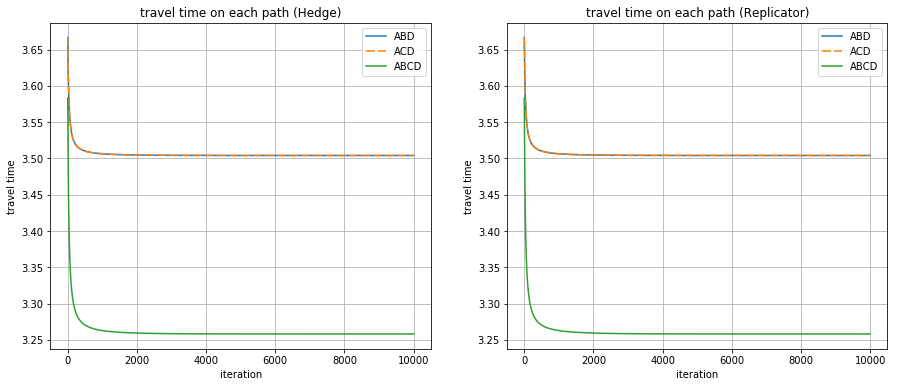

In [9]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T)
plt.plot(time, ttravel_Hedge_lambda[:,0], label='ABD')
plt.plot(time, ttravel_Hedge_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Hedge_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)

time = range(T)
plt.plot(time, ttravel_Replicator_lambda[:,0], label='ABD')
plt.plot(time, ttravel_Replicator_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Replicator_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator)')
plt.grid()
plt.legend()
plt.show()

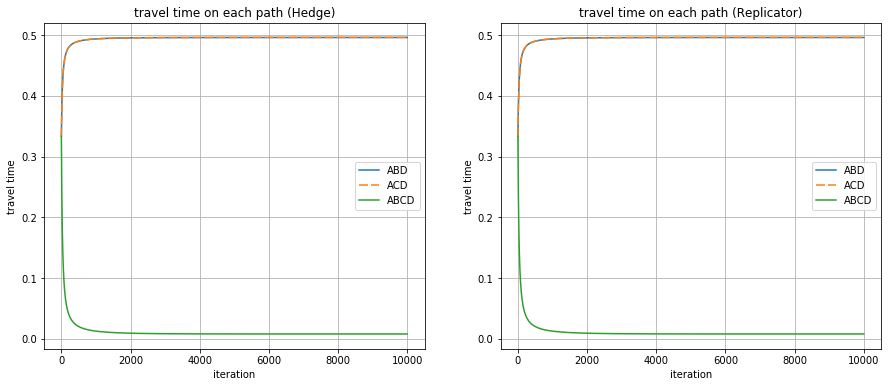

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T+1)
plt.plot(time, f_Hedge_lambda[:,0], label='ABD')
plt.plot(time, f_Hedge_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Hedge_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)

time = range(T+1)
plt.plot(time, f_Replicator_lambda[:,0], label='ABD')
plt.plot(time, f_Replicator_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Replicator_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator)')
plt.grid()
plt.legend()
plt.show()

### Remark:
- $\frac{1}{\sqrt{t}}$ learning rate does work but the convergence rate is slow; the exponential decay rate works as well (get the correct equilibrium) but the convergence rate is way better.

### Example 2

In [287]:
class Network2(object):
    """Stores the cost for all links. Handles calculating the cost of a path given action
       of every car.
    """
    def __init__(self):
        self.__links = {
            "01": lambda f: f + 2., 
            "04": lambda f: f/2,
            "05": lambda f: f,
            "51": lambda f: f/3,
            "45": lambda f: 3*f, 
            "43": lambda f: f, 
            "24": lambda _: 0.5,
            "23": lambda f: f + 1.,
            "53": lambda f: f/4
        } # Dictionary of links and their congestion functions
        self.__paths = {
            "01": ("01","11"),
            "051": ("05", "51"),
            "0451": ("04", "45", "51"),
            "23": ("23","33"),
            "243": ("24","43"),
            "2453": ("24","45","53")
        } # Dictionaries of paths to links
        return 
    
    def paths(self, population):
        """Gives a list of all possible paths in the network to the environment. 
           The environment could then assign an action number to each path. 
        """
        if population == 0:
            return ("01", "051", "0451")
        elif population == 1:
            return ("23", "243", "2453")
        else:
            return "no such population"
        
    def shared_link(self): # a simple link for this example, need more generalized utility function for more comlicated networks
        return "45" 
    
    def calculate_ttime(self, flows): # flows now is a dictionary; add flow before feeding into the cost fct
        """Given a dictionary of paths and flows, this function returns a dictionary of 
           paths and travel time (secs), a.k.a ttime.
           
           Returns: 
               travel_times (dictionary): A dictionary of paths to their travel times
        """
        congestion = {}
        for population in flows:
            for path in flows[str(population)]:
                links = self.__paths[path]
                for link in links:
                    if link not in self.__links:
                        break
                    if link not in congestion:
                        congestion[link] = 0
                    congestion[link] += flows[str(population)][path]
                    
        t_time = {}
        for population in flows:
            t_time[population] = {}
            for path in flows[population]:
                total_time = 0
                # Calculate travel time of path by adding the congestion time of every 
                # link in that path
                links = self.__paths[path]
                for link in links:
                    if link not in self.__links:
                        break
                    t_time_func = self.__links[link]
                    total_time += t_time_func(congestion[link])
                t_time[population][path] = total_time
        
        return t_time
        
        
    def calculate_ttime_lambda(self, flows, Lambda):
        """Given a dictionary of paths and flows, this function returns a dictionary of 
           paths and travel time, considering the social factor lambda (secs).
           
           Returns: 
               travel_times (dictionary): A dictionary of paths to their travel times,
               considering the social factor lambda
        """
        congestion = {}
        for population in flows:
            for path in flows[str(population)]:
                links = self.__paths[path]
                for link in links:
                    if link not in self.__links:
                        break
                    if link not in congestion:
                        congestion[link] = 0
                    congestion[link] += flows[str(population)][path]
        
        t_time_lambda  = {}
        for population in flows:
            t_time_lambda[population] = {}
            for path in flows[population]:
                total_time = 0
                # Calculate travel time of path by adding the congestion time of every 
                # link in that path
                links = self.__paths[path]
                for link in links:
                    if link not in self.__links:
                        break
                    if link == "01" or link == "05" or link == "43" or link == "23":
                        total_time += Lambda * congestion[link]
                    elif link == "04":
                        total_time += Lambda * congestion[link] * 0.5
                    elif link == "51":
                        total_time += Lambda * congestion[link] / 3
                    elif link == "45":
                        total_time += Lambda * congestion[link] * 3
                    elif link == "53":
                        total_time += Lambda * congestion[link] / 4
                    t_time_func = self.__links[link]
                    total_time += t_time_func(congestion[link])
                t_time_lambda [population][path] = total_time
        return t_time_lambda

In [288]:
Network = Network2()

T = 100
rho = 4 

flow_exp = {"0":[1/3]*3,"1":[1/3]*3} # two populations, define the flow as a 2 element dictionary
flow_sqrt = {"0":[1/3]*3,"1":[1/3]*3}

flows_Hedge_exp = {} # dictionary of the flow for two populations
flows_Hedge_sqrt = {}
for i in range(2):
    flows_Hedge_exp[str(i)] = dict(zip(Network.paths(i), flow_exp[str(i)]))
    flows_Hedge_sqrt[str(i)] = dict(zip(Network.paths(i), flow_exp[str(i)]))
    
ttravel_Hedge_exp = {}
ttravel_Hedge_exp["0"] = np.zeros((T,3))
ttravel_Hedge_exp["1"] = np.zeros((T,3))
f_Hedge_exp = {}
f_Hedge_exp["0"] = np.zeros((T+1,3))
f_Hedge_exp["1"] = np.zeros((T+1,3))
f_Hedge_exp["0"][0,:] = flow_exp["0"]
f_Hedge_exp["1"][0,:] = flow_exp["0"]

ttravel_Hedge_sqrt = {}
ttravel_Hedge_sqrt["0"] = np.zeros((T,3))
ttravel_Hedge_sqrt["1"] = np.zeros((T,3))
f_Hedge_sqrt = {}
f_Hedge_sqrt["0"] = np.zeros((T+1,3))
f_Hedge_sqrt["1"] = np.zeros((T+1,3))
f_Hedge_sqrt["0"][0,:] = flow_sqrt["0"]
f_Hedge_sqrt["1"][0,:] = flow_sqrt["0"]

# Hedge
for i in range(T):
    learning_rate_exp = (0.999)**i
    learning_rate_sqrt = 1/np.sqrt(i+1)
    
    travel_time_exp = Network.calculate_ttime(flows_Hedge_exp)
    travel_time_sqrt = Network.calculate_ttime(flows_Hedge_sqrt)

    for j in range(2):
        ttravel_Hedge_exp[str(j)][i,:] = np.array(list(travel_time_exp[str(j)].values()))
        flow_exp[str(j)] *= np.exp(-learning_rate_exp*np.array(list(travel_time_exp[str(j)].values()))/rho)  # hedge update
        flow_exp[str(j)] /= sum(flow_exp[str(j)])
        f_Hedge_exp[str(j)][i+1,:] = flow_exp[str(j)]
        flows_Hedge_exp[str(j)] = dict(zip(Network.paths(j),flow_exp[str(j)]))
    
        ttravel_Hedge_sqrt[str(j)][i,:] = np.array(list(travel_time_sqrt[str(j)].values()))
        flow_sqrt[str(j)] *= np.exp(-learning_rate_sqrt*np.array(list(travel_time_sqrt[str(j)].values()))/rho)  # hedge update
        flow_sqrt[str(j)] /= sum(flow_sqrt[str(j)])
        f_Hedge_sqrt[str(j)][i+1,:] = flow_sqrt[str(j)]
        flows_Hedge_sqrt[str(j)] = dict(zip(Network.paths(j),flow_sqrt[str(j)]))

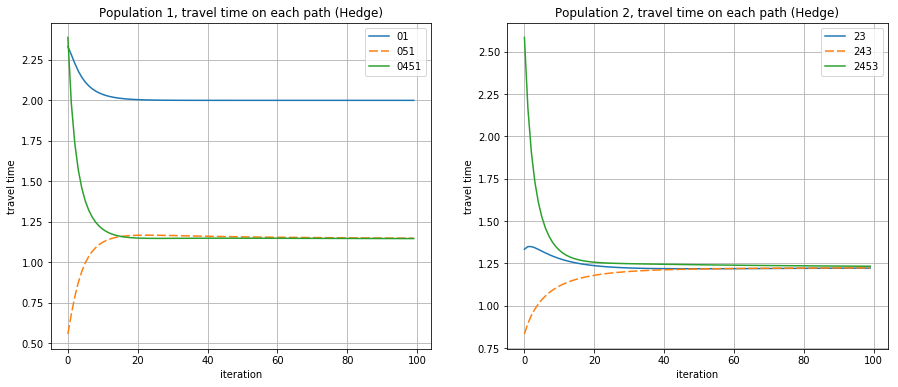

In [289]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T)
plt.plot(time, ttravel_Hedge_exp["0"][:,0], label='01')
plt.plot(time, ttravel_Hedge_exp["0"][:,1], dashes=[6, 2], label='051')
plt.plot(time, ttravel_Hedge_exp["0"][:,2], label='0451')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 1, travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time, ttravel_Hedge_exp["1"][:,0], label='23')
plt.plot(time, ttravel_Hedge_exp["1"][:,1], dashes=[6, 2], label='243')
plt.plot(time, ttravel_Hedge_exp["1"][:,2], label='2453')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 2, travel time on each path (Hedge)')
plt.grid()
plt.legend()
plt.show()

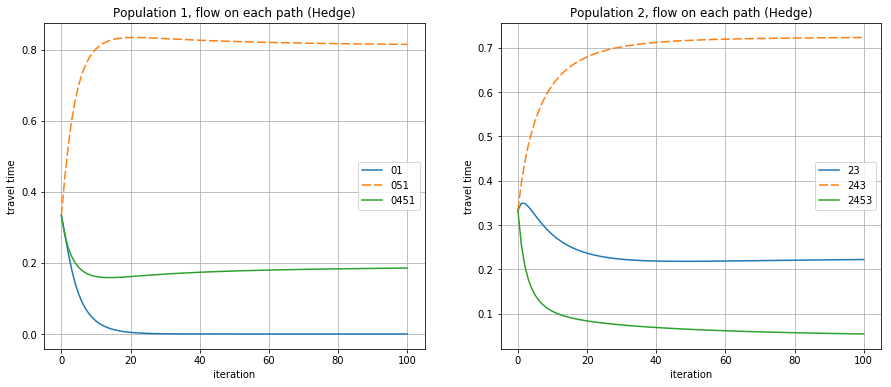

In [290]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T+1)
plt.plot(time, f_Hedge_exp["0"][:,0], label='01')
plt.plot(time, f_Hedge_exp["0"][:,1], dashes=[6, 2], label='051')
plt.plot(time, f_Hedge_exp["0"][:,2], label='0451')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 1, flow on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time, f_Hedge_exp["1"][:,0], label='23')
plt.plot(time, f_Hedge_exp["1"][:,1], dashes=[6, 2], label='243')
plt.plot(time, f_Hedge_exp["1"][:,2], label='2453')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 2, flow on each path (Hedge)')
plt.grid()
plt.legend()
plt.show()

In [300]:
Network = Network2()

Lambda = 0.9

T = 500
rho = 4 + 4*Lambda

flow_lambda = {"0":[1/3]*3,"1":[1/3]*3} # two populations, define the flow as a 2 element dictionary

flows_Hedge_lambda = {} # dictionary of the flow for two populations
for i in range(2):
    flows_Hedge_lambda[str(i)] = dict(zip(Network.paths(i), flow_lambda[str(i)]))
    
ttravel_Hedge_lambda = {}
ttravel_Hedge_lambda["0"] = np.zeros((T,3))
ttravel_Hedge_lambda["1"] = np.zeros((T,3))
f_Hedge_lambda = {}
f_Hedge_lambda["0"] = np.zeros((T+1,3))
f_Hedge_lambda["1"] = np.zeros((T+1,3))
f_Hedge_lambda["0"][0,:] = flow_lambda["0"]
f_Hedge_lambda["1"][0,:] = flow_lambda["0"]



# Hedge
for i in range(T):
    learning_rate_exp = (0.999)**i
   
    travel_time_lambda = Network.calculate_ttime_lambda(flows_Hedge_lambda, Lambda)
    travel_time = Network.calculate_ttime(flows_Hedge_lambda)
    
    for j in range(2):
        """
        ttravel_Hedge_exp[str(j)][i,:] = np.array(list(travel_time_exp[str(j)].values()))
        """
        ttravel_Hedge_lambda[str(j)][i,:] = np.array(list(travel_time[str(j)].values()))
        flow_lambda[str(j)] *= np.exp(-learning_rate_exp*np.array(list(travel_time_lambda[str(j)].values()))/rho)  # hedge update
        flow_lambda[str(j)] /= sum(flow_lambda[str(j)])
        f_Hedge_lambda[str(j)][i+1,:] = flow_lambda[str(j)]
        flows_Hedge_lambda[str(j)] = dict(zip(Network.paths(j),flow_lambda[str(j)]))

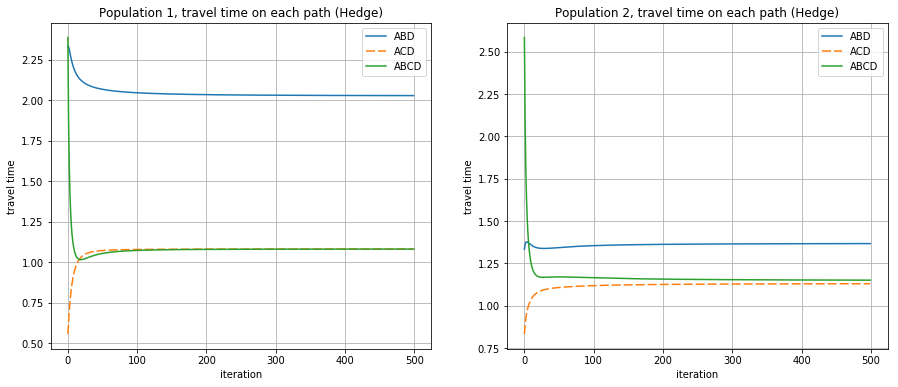

In [301]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T)
plt.plot(time, ttravel_Hedge_lambda["0"][:,0], label='ABD')
plt.plot(time, ttravel_Hedge_lambda["0"][:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Hedge_lambda["0"][:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 1, travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time, ttravel_Hedge_lambda["1"][:,0], label='ABD')
plt.plot(time, ttravel_Hedge_lambda["1"][:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Hedge_lambda["1"][:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 2, travel time on each path (Hedge)')
plt.grid()
plt.legend()
plt.show()

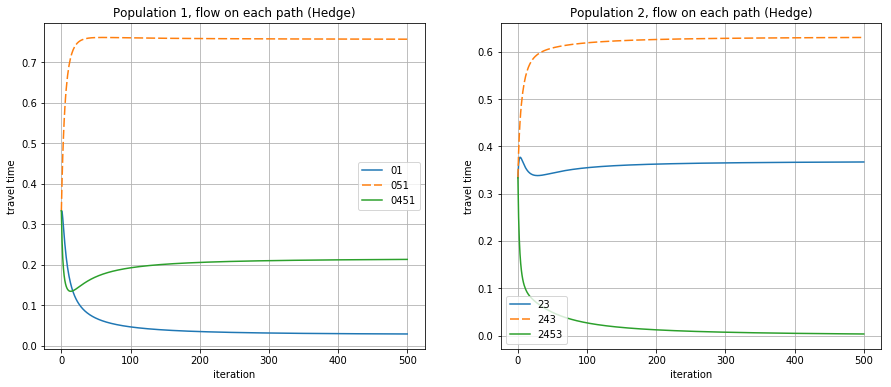

In [302]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T+1)
plt.plot(time, f_Hedge_lambda["0"][:,0], label='01')
plt.plot(time, f_Hedge_lambda["0"][:,1], dashes=[6, 2], label='051')
plt.plot(time, f_Hedge_lambda["0"][:,2], label='0451')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 1, flow on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time, f_Hedge_lambda["1"][:,0], label='23')
plt.plot(time, f_Hedge_lambda["1"][:,1], dashes=[6, 2], label='243')
plt.plot(time, f_Hedge_lambda["1"][:,2], label='2453')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('Population 2, flow on each path (Hedge)')
plt.grid()
plt.legend()
plt.show()